In [1]:
import os
import glob
import pickle
import time
import json

os.environ["PRIVBAYES_BIN"] = "./ydnpd/harness/synthesis/privbayes/mac_bin"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns
import scienceplots


import ydnpd
from additional import ADDITIONAL_EXPERIMENTS, ADDITIONAL_PATH
from ydnpd import EVALUATION_METRICS, ALL_EXPERIMENTS, Experiments

ADDITIONAL_DATASETS = sum(list(ADDITIONAL_EXPERIMENTS.values()), [])

with open("./results/harness-gen.pkl", "rb") as f:
    utility_tasks_results_gem = pickle.load(f)

with open("./results/harness-multi.pkl", "rb") as f:
    utility_tasks_results_multi = pickle.load(f)

utility_tasks_results = utility_tasks_results_multi + utility_tasks_results_gem

for x in utility_tasks_results:
    if type(x["evaluation"]["error_rate_diff"]) == list:
        assert len(x["evaluation"]["error_rate_diff"]) == 1
        x["evaluation"]["error_rate_diff"] = x["evaluation"]["error_rate_diff"][0]

utility_tasks_results = [x for x in utility_tasks_results if "sdscm" not in x["dataset_name"].lower()]

missing_metrics = {}
for x in utility_tasks_results:
    for metric in EVALUATION_METRICS:
        if np.isnan(x["evaluation"][metric]):
            missing_metrics[x["dataset_name"]] = missing_metrics.get(x["dataset_name"], []) + [metric]
all_results = utility_tasks_results.copy()

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

METRIC_DIRECTION = {
    "total_variation_distance": "closer_to_zero_is_better",
    "pearson_corr_max_abs_diff": "closer_to_zero_is_better",
    "pearson_corr_avg_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_max_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_avg_abs_diff": "closer_to_zero_is_better",
    "marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "error_rate_diff": "closer_to_zero_is_better",
    "auc_diff": "closer_to_zero_is_better",
}

CORRELATION_METRICS = [
    "total_variation_distance",
    "pearson_corr_max_abs_diff",
    "pearson_corr_avg_abs_diff",
    "cramer_v_corr_max_abs_diff",
    "cramer_v_corr_avg_abs_diff",
]
MARGINALS_METRICS = [
    "marginals_3_max_abs_diff_error",
    "marginals_3_avg_abs_diff_error",
    "thresholded_marginals_3_max_abs_diff_error",
    "thresholded_marginals_3_avg_abs_diff_error",
]
CLASSIFICATION_METRICS = [
    "error_rate_diff",
    "auc_diff",
]


# synth method human readable
synth_method_name_map = {
    "gem": "GEM",
    "privbayes": "PrivBayes",
    "aim_jax": "AIM",
}

metric_group_map = {
    "correlation_metrics": "Correlation",
    "classification_metrics": "Classification",
    "marginals_metrics": "Marginals"
}

# ref ds map
reference_dataset_name_map = {
    "acs/national": "ACS",
    "edad/2023": "EDAD",
    "we/2023": "WE",
}

we_method_name_map = {
    "we/2018": "Public",
    "we/2023": "Private",
    "we/arbitrary": "Arbitrary",
    "we/baseline_domain": "Domain (Baseline)",
    "we/baseline_univariate": "Univariate (Baseline)",
    "we/csv-claude": "CSV (Claude 3.5 Sonnet)",
    "we/csv-gpt": "CSV (GPT-4o)",
    "we/csv-llama": "CSV (Llama 3.3 70B)",
    "we/gen-MIX-MAX": "Agent (All, Max Cov.)",
    "we/gen-MIX-UNIF": "Agent (All, Unif.)",
    "we/gen-claude-MIX-MAX": "Agent (Claude 3.5 Sonnet, Max Cov.)",
    "we/gen-claude-MIX-UNIF": "Agent (Claude 3.5 Sonnet, Unif.)",
    "we/gen-gpt-MIX-MAX": "Agent (GPT-4o, Max Cov.)",
    "we/gen-gpt-MIX-UNIF": "Agent (GPT-4o, Unif.)",
    "we/gen-llama-MIX-MAX": "Agent (Llama 3.3 70B, Max Cov.)",
    "we/gen-llama-MIX-UNIF": "Agent (Llama 3.3 70B, Unif.)",
    "we/sdscm-gpt2": "SDSCM (GPT-2)",
    "we/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "we/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

acs_method_name_map = {
    "acs/arbitrary": "Arbitrary",
    "acs/baseline_domain": "Domain (Baseline)",
    "acs/baseline_univariate": "Univariate (Baseline)",
    "acs/csv-claude": "CSV (Claude 3.5 Sonnet)",
    "acs/csv-gpt": "CSV (GPT-4o)",
    "acs/csv-llama": "CSV (Llama 3.3 70B)",
    "acs/gen-MIX-MAX": "Agent (All, Max Cov.)",
    "acs/gen-MIX-UNIF": "Agent (All, Unif.)",
    "acs/gen-claude-MIX-MAX": "Agent (Claude 3.5 Sonnet, Max Cov.)",
    "acs/gen-claude-MIX-UNIF": "Agent (Claude 3.5 Sonnet, Unif.)",
    "acs/gen-gpt-MIX-MAX": "Agent (GPT-4o, Max Cov.)",
    "acs/gen-gpt-MIX-UNIF": "Agent (GPT-4o, Unif.)",
    "acs/gen-llama-MIX-MAX": "Agent (Llama 3.3 70B, Max Cov.)",
    "acs/gen-llama-MIX-UNIF": "Agent (Llama 3.3 70B, Unif.)",
    "acs/massachusetts_upsampled": "Public",
    "acs/national": "Private",
    "acs/sdscm-gpt2": "SDSCM (GPT-2)",
    "acs/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "acs/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

edad_method_name_map = {
    "edad/2020": "Public",
    "edad/2023": "Private",
    "edad/arbitrary": "Arbitrary",
    "edad/baseline_domain": "Domain (Baseline)",
    "edad/baseline_univariate": "Univariate (Baseline)",
    "edad/csv-claude": "CSV (Claude 3.5 Sonnet)",
    "edad/csv-gpt": "CSV (GPT-4o)",
    "edad/csv-llama": "CSV (Llama 3.3 70B)",
    "edad/gen-MIX-MAX": "Agent (All, Max Cov.)",
    "edad/gen-MIX-UNIF": "Agent (All, Unif.)",
    "edad/gen-claude-MIX-MAX": "Agent (Claude 3.5 Sonnet, Max Cov.)",
    "edad/gen-claude-MIX-UNIF": "Agent (Claude 3.5 Sonnet, Unif.)",
    "edad/gen-gpt-MIX-MAX": "Agent (GPT-4o, Max Cov.)",
    "edad/gen-gpt-MIX-UNIF": "Agent (GPT-4o, Unif.)",
    "edad/gen-llama-MIX-MAX": "Agent (Llama 3.3 70B, Max Cov.)",
    "edad/gen-llama-MIX-UNIF": "Agent (Llama 3.3 70B, Unif.)",
    "edad/sdscm-gpt2": "SDSCM (GPT-2)",
    "edad/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "edad/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}


rename_map = {
    "pct_degradation_on_ref": "% Degradation on Ref."
}

method_grouping = {
    "Arbitrary": "Arbitrary",
    "Domain (Baseline)": "Baseline",
    "Univariate (Baseline)": "Baseline",
    "CSV (Claude 3.5 Sonnet)": "CSV",
    "CSV (GPT-4o)": "CSV",
    "CSV (Llama 3.3 70B)":  "CSV",
    "Agent (All, Max Cov.)": "Agent",
    "Agent (All, Unif.)": "Agent",
    "Agent (Llama 3.3 70B, Max Cov.)": "Agent",
    "Agent (Llama 3.3 70B, Unif.)": "Agent",
    "Agent (Claude 3.5 Sonnet, Max Cov.)": "Agent",
    "Agent (Claude 3.5 Sonnet, Unif.)": "Agent",
    "Agent (GPT-4o, Max Cov.)": "Agent",
    "Agent (GPT-4o, Unif.)": "Agent",
    "SDSCM (GPT-2)": "SDSCM",
    "SDSCM (LLaMA-3 8B)": "SDSCM",
    "SDSCM (OLMO-1B HF)":  "SDSCM",
    "Public": "Public",
    "Private": "Private"
}

grouping_colors = {
    # grey color
    "Baseline": "grey",
    'Arbitrary': 'blue',
    'Public': 'magenta',
    # green
    "CSV": "#228B22",
    # orange
    "Agent": "#FF8C00",
    # brown
    "SDSCM": "#8B4513",
    # other should be magenta
    "Other": "black"
}

df = pd.DataFrame(all_results)

df_evaluation = pd.json_normalize(df["evaluation"])

def dict_to_sorted_json_str(d):
    return str(json.dumps(d, sort_keys=True)) # str(

df["hparams_str"] = df["hparams"].apply(dict_to_sorted_json_str)

df_combined = pd.concat(
    [df.drop(columns=["hparams", "evaluation"]),
     df_evaluation],
    axis=1
)

# group by hparams_str, take the mean
df_combined = df_combined[['hparams_str', 'synth_name', 'epsilon', 'dataset_name'] + list(METRIC_DIRECTION.keys())].groupby(['hparams_str', 'synth_name', 'epsilon', 'dataset_name']).mean().reset_index()

def get_reference_dataset_name(ds_name):
    if ds_name.startswith("acs/"):
        return reference_data_mapping["acs"]
    elif ds_name.startswith("edad/"):
        return reference_data_mapping["edad"]
    elif ds_name.startswith("we/"):
        return reference_data_mapping["we"]
    else:
        raise ValueError(f"Unknown dataset name: {ds_name}")

df_combined["reference_dataset_name"] = df_combined["dataset_name"].apply(get_reference_dataset_name)

def find_best_performance_rows(subdf, metric):
    direction = METRIC_DIRECTION[metric]
    if direction == "closer_to_zero_is_better":
        best_val = subdf[metric].abs().min()
        best_hparams_str = subdf[subdf[metric].abs() == best_val]["hparams_str"].iloc[0]
        return subdf[subdf[metric].abs() == best_val], best_hparams_str
    else:
        raise ValueError(f"everything is closer_to_zero_is_better now")
    
rows_for_report = []

# skipped tracker
skipped = {}
group_cols = ["synth_name", "epsilon", "reference_dataset_name"]
for (synth_name, epsilon, reference_dataset_name), group_df in df_combined.groupby(group_cols):
    # identify the reference dataset within this group
    ref_df = group_df[group_df["dataset_name"] == reference_dataset_name]
    if ref_df.empty:
        continue

    # find the 'true best performance' for each metric in that reference subset
    true_best_performance = {}
    for metric in METRIC_DIRECTION.keys():
        best_rows, best_hparams = find_best_performance_rows(ref_df, metric)
        # just pick the first row in case of tie
        best_row = best_rows.iloc[0]
        true_best_val = np.abs(best_row[metric])
        true_best_performance[metric] = (true_best_val, best_row, best_hparams)

    # for each dataset in the group, figure out which hyperparams you'd pick
    for ds_name, ds_group_df in group_df.groupby("dataset_name"):

        # then do that for each metric (or each metric block)
        for metric in METRIC_DIRECTION.keys():
            try:
                best_ds_rows, _ = find_best_performance_rows(ds_group_df, metric)
                chosen_row = best_ds_rows.iloc[0]  # pick first in tie
                chosen_hparams_str = chosen_row["hparams_str"]

                # now we see if that same hparams_str is present in the reference df
                ref_match = ref_df[ref_df["hparams_str"] == chosen_hparams_str]
                if ref_match.empty:
                    # means reference never had that exact set of hyperparams
                    raise ValueError(f"whoops")

                # how does it perform on the reference dataset?
                row_in_ref = ref_match.iloc[0]
                perf_on_ref = np.abs(row_in_ref[metric])

                # get the "true best" value for that metric
                (true_best_val, _, best_hparams) = true_best_performance[metric]

                # define percent_degradation = (candidate - best) / abs(best), if best != 0, else 0
                if true_best_val == 0:
                    pct_degradation = 0
                else:
                    pct_degradation = (perf_on_ref - true_best_val) / abs(true_best_val)

                # store in our report
                rows_for_report.append({
                    "synth_name": synth_name,
                    "epsilon": epsilon,
                    "dataset_name": ds_name,
                    "metric": metric,
                    "chosen_hparams_str": chosen_hparams_str,
                    "chosen_val_on_dataset": np.abs(chosen_row[metric]),
                    "perf_on_reference": perf_on_ref,
                    "true_best_on_reference": true_best_val,
                    "pct_degradation_on_ref": pct_degradation,
                    "best_hparams": best_hparams,
                    "reference_dataset_name": reference_dataset_name,
                })
            except Exception as e:
                print(f"Skipping {synth_name}, {epsilon}, {ds_name}, {metric}: {e}")
                if (synth_name, epsilon, ds_name, metric) not in skipped:
                    skipped[(synth_name, epsilon, ds_name, metric)] = 0
                skipped[(synth_name, epsilon, ds_name, metric)] += 1


report_df = pd.DataFrame(rows_for_report)

METRIC_GROUPS = {
    "correlation_metrics": [
        "total_variation_distance",
        "pearson_corr_max_abs_diff",
        "pearson_corr_avg_abs_diff",
        "cramer_v_corr_max_abs_diff",
        "cramer_v_corr_avg_abs_diff",
    ],
    "marginals_metrics": [
        "marginals_3_max_abs_diff_error",
        "marginals_3_avg_abs_diff_error",
        "thresholded_marginals_3_max_abs_diff_error",
        "thresholded_marginals_3_avg_abs_diff_error",
    ],
    "classification_metrics": [
        "error_rate_diff",
        "auc_diff",
    ],
}

# reverse mapping, metric -> group
metric_to_group = {}
for group, metrics in METRIC_GROUPS.items():
    for metric in metrics:
        metric_to_group[metric] = group

# metric_group to column to report_df
report_df['metric_group'] = report_df['metric'].map(metric_to_group)


Skipping aim_jax, 1, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-MAX, auc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, auc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-MAX, auc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, auc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 4, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 4, edad/gen-llama-MIX-MAX, auc_diff: single positional indexe

metric_group: correlation_metrics

synthesizer: privbayes
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,privbayes
11,acs/gen-gpt-MIX-UNIF,0.051520,0.028064,acs/national,privbayes
14,acs/massachusetts_upsampled,0.054967,0.028807,acs/national,privbayes
13,acs/gen-llama-MIX-UNIF,0.052923,0.030715,acs/national,privbayes
0,acs/arbitrary,0.056766,0.033592,acs/national,privbayes
10,acs/gen-gpt-MIX-MAX,0.062078,0.037006,acs/national,privbayes
9,acs/gen-claude-MIX-UNIF,0.068906,0.037075,acs/national,privbayes
8,acs/gen-claude-MIX-MAX,0.079203,0.040298,acs/national,privbayes
6,acs/gen-MIX-MAX,0.074195,0.041831,acs/national,privbayes
12,acs/gen-llama-MIX-MAX,0.092145,0.043835,acs/national,privbayes


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


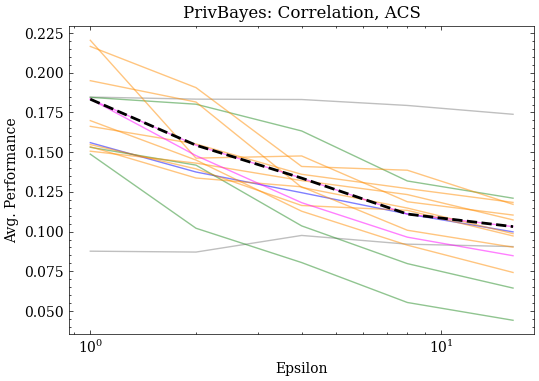

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,privbayes
0,edad/2020,0.046728,0.022459,edad/2023,privbayes
8,edad/gen-MIX-MAX,0.074767,0.038296,edad/2023,privbayes
2,edad/arbitrary,0.085341,0.046001,edad/2023,privbayes
9,edad/gen-MIX-UNIF,0.108234,0.061927,edad/2023,privbayes
11,edad/gen-claude-MIX-UNIF,0.145452,0.082001,edad/2023,privbayes
10,edad/gen-claude-MIX-MAX,0.159158,0.091971,edad/2023,privbayes
12,edad/gen-gpt-MIX-MAX,0.212354,0.119649,edad/2023,privbayes
6,edad/csv-gpt,0.272423,0.129567,edad/2023,privbayes
13,edad/gen-gpt-MIX-UNIF,0.258021,0.146484,edad/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


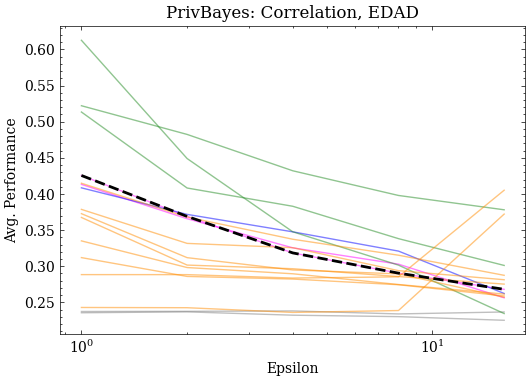

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,privbayes
0,we/2018,0.052021,0.031217,we/2023,privbayes
2,we/arbitrary,0.111443,0.057818,we/2023,privbayes
10,we/gen-claude-MIX-MAX,0.129994,0.062614,we/2023,privbayes
15,we/gen-llama-MIX-UNIF,0.141916,0.070867,we/2023,privbayes
8,we/gen-MIX-MAX,0.132781,0.074050,we/2023,privbayes
9,we/gen-MIX-UNIF,0.144173,0.074380,we/2023,privbayes
11,we/gen-claude-MIX-UNIF,0.143663,0.075998,we/2023,privbayes
14,we/gen-llama-MIX-MAX,0.171468,0.077483,we/2023,privbayes
12,we/gen-gpt-MIX-MAX,0.279829,0.128430,we/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


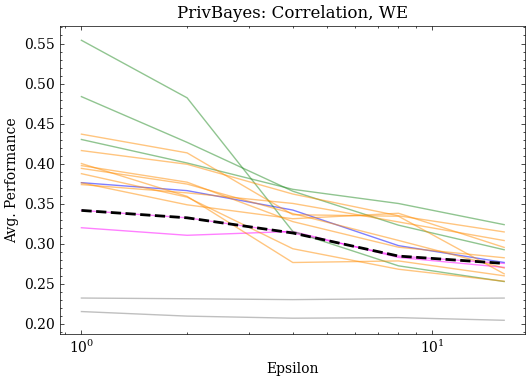


synthesizer: aim_jax
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,aim_jax
6,acs/gen-MIX-MAX,0.354712,0.166413,acs/national,aim_jax
13,acs/gen-llama-MIX-UNIF,0.308853,0.168313,acs/national,aim_jax
0,acs/arbitrary,0.394683,0.178706,acs/national,aim_jax
14,acs/massachusetts_upsampled,0.333857,0.210403,acs/national,aim_jax
8,acs/gen-claude-MIX-MAX,0.511149,0.250155,acs/national,aim_jax
12,acs/gen-llama-MIX-MAX,0.469626,0.267795,acs/national,aim_jax
4,acs/csv-gpt,0.532823,0.292571,acs/national,aim_jax
7,acs/gen-MIX-UNIF,0.559085,0.321891,acs/national,aim_jax
5,acs/csv-llama,0.650356,0.335066,acs/national,aim_jax


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


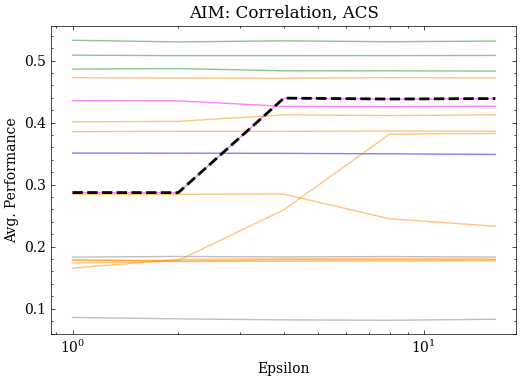

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,aim_jax
0,edad/2020,0.091869,0.049227,edad/2023,aim_jax
9,edad/gen-MIX-UNIF,0.110581,0.050223,edad/2023,aim_jax
2,edad/arbitrary,0.140995,0.072398,edad/2023,aim_jax
8,edad/gen-MIX-MAX,0.264772,0.118806,edad/2023,aim_jax
10,edad/gen-claude-MIX-MAX,0.332796,0.148980,edad/2023,aim_jax
11,edad/gen-claude-MIX-UNIF,0.374231,0.167604,edad/2023,aim_jax
12,edad/gen-gpt-MIX-MAX,0.400756,0.179289,edad/2023,aim_jax
13,edad/gen-gpt-MIX-UNIF,0.509023,0.227704,edad/2023,aim_jax
14,edad/gen-llama-MIX-MAX,0.606883,0.272959,edad/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


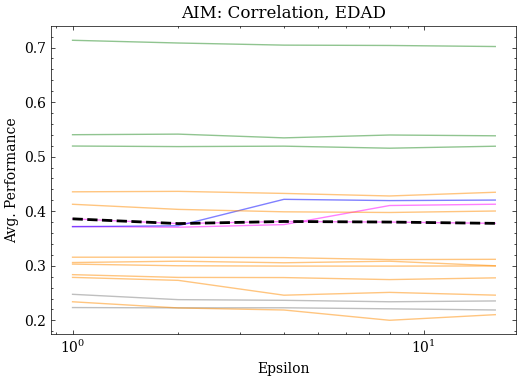

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,aim_jax
15,we/gen-llama-MIX-UNIF,0.044973,0.020616,we/2023,aim_jax
0,we/2018,0.120039,0.053921,we/2023,aim_jax
2,we/arbitrary,0.161916,0.073038,we/2023,aim_jax
10,we/gen-claude-MIX-MAX,0.222272,0.099582,we/2023,aim_jax
14,we/gen-llama-MIX-MAX,0.229890,0.102946,we/2023,aim_jax
11,we/gen-claude-MIX-UNIF,0.238225,0.106641,we/2023,aim_jax
8,we/gen-MIX-MAX,0.299482,0.134284,we/2023,aim_jax
9,we/gen-MIX-UNIF,0.356694,0.159576,we/2023,aim_jax
3,we/baseline_domain,0.498252,0.222852,we/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


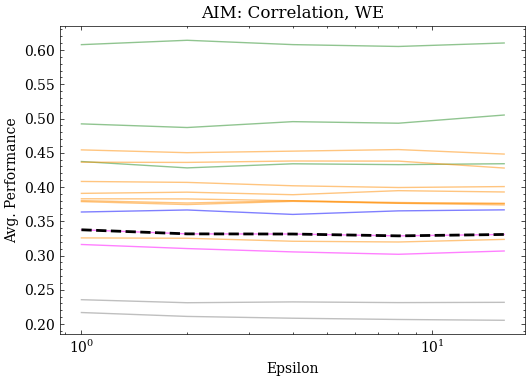


synthesizer: gem
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,gem
6,acs/gen-MIX-MAX,0.045135,0.021008,acs/national,gem
4,acs/csv-gpt,0.047645,0.023787,acs/national,gem
10,acs/gen-gpt-MIX-MAX,0.053501,0.024818,acs/national,gem
2,acs/baseline_univariate,0.053801,0.025070,acs/national,gem
11,acs/gen-gpt-MIX-UNIF,0.055848,0.025299,acs/national,gem
7,acs/gen-MIX-UNIF,0.070282,0.031984,acs/national,gem
14,acs/massachusetts_upsampled,0.102685,0.046372,acs/national,gem
9,acs/gen-claude-MIX-UNIF,0.133385,0.059710,acs/national,gem
1,acs/baseline_domain,0.179656,0.080652,acs/national,gem


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


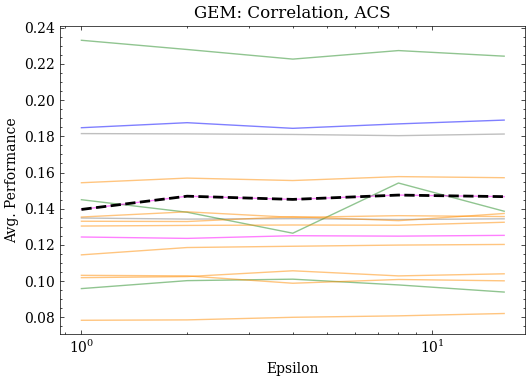

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,gem
8,edad/gen-MIX-MAX,0.011062,0.006299,edad/2023,gem
0,edad/2020,0.020716,0.011024,edad/2023,gem
3,edad/baseline_domain,0.033878,0.016743,edad/2023,gem
9,edad/gen-MIX-UNIF,0.033770,0.017254,edad/2023,gem
13,edad/gen-gpt-MIX-UNIF,0.040482,0.018734,edad/2023,gem
12,edad/gen-gpt-MIX-MAX,0.046155,0.021081,edad/2023,gem
4,edad/baseline_univariate,0.065422,0.029884,edad/2023,gem
11,edad/gen-claude-MIX-UNIF,0.069978,0.033067,edad/2023,gem
10,edad/gen-claude-MIX-MAX,0.115867,0.052121,edad/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)


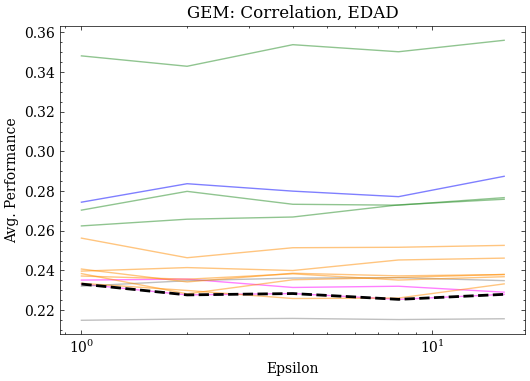

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,gem
6,we/csv-gpt,0.036308,0.017341,we/2023,gem
7,we/csv-llama,0.032926,0.019191,we/2023,gem
12,we/gen-gpt-MIX-MAX,0.061960,0.030173,we/2023,gem
2,we/arbitrary,0.073279,0.034501,we/2023,gem
13,we/gen-gpt-MIX-UNIF,0.089335,0.046522,we/2023,gem
8,we/gen-MIX-MAX,0.132176,0.059667,we/2023,gem
0,we/2018,0.131618,0.059697,we/2023,gem
9,we/gen-MIX-UNIF,0.195591,0.088173,we/2023,gem
5,we/csv-claude,0.214871,0.097214,we/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


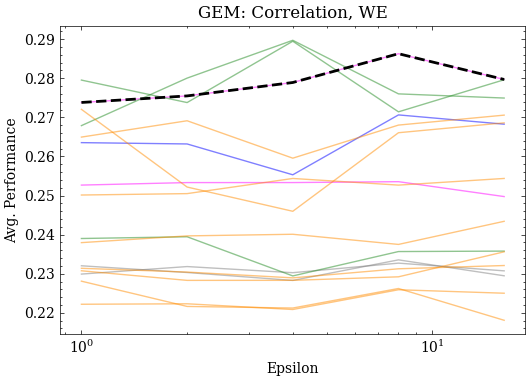

metric_group: marginals_metrics

synthesizer: privbayes
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,privbayes
5,acs/csv-llama,0.011660,0.006758,acs/national,privbayes
6,acs/gen-MIX-MAX,0.020596,0.013694,acs/national,privbayes
13,acs/gen-llama-MIX-UNIF,0.034767,0.017230,acs/national,privbayes
14,acs/massachusetts_upsampled,0.031796,0.017791,acs/national,privbayes
12,acs/gen-llama-MIX-MAX,0.031740,0.017803,acs/national,privbayes
4,acs/csv-gpt,0.062509,0.029122,acs/national,privbayes
7,acs/gen-MIX-UNIF,0.064224,0.030740,acs/national,privbayes
3,acs/csv-claude,0.067280,0.030819,acs/national,privbayes
0,acs/arbitrary,0.104805,0.050733,acs/national,privbayes


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


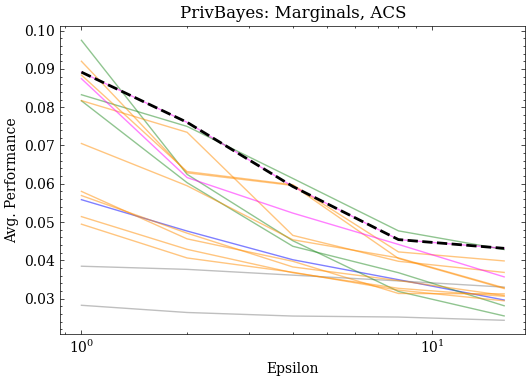

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,privbayes
9,edad/gen-MIX-UNIF,0.071465,0.036252,edad/2023,privbayes
0,edad/2020,0.088082,0.047620,edad/2023,privbayes
8,edad/gen-MIX-MAX,0.102840,0.050637,edad/2023,privbayes
11,edad/gen-claude-MIX-UNIF,0.124736,0.073613,edad/2023,privbayes
10,edad/gen-claude-MIX-MAX,0.116002,0.076495,edad/2023,privbayes
12,edad/gen-gpt-MIX-MAX,0.136601,0.079884,edad/2023,privbayes
2,edad/arbitrary,0.181054,0.106511,edad/2023,privbayes
13,edad/gen-gpt-MIX-UNIF,0.181486,0.111594,edad/2023,privbayes
6,edad/csv-gpt,0.297383,0.134770,edad/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


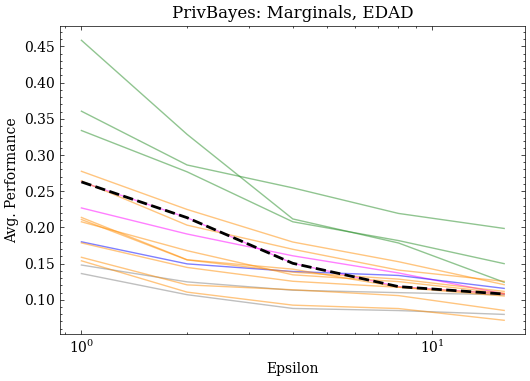

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,privbayes
11,we/gen-claude-MIX-UNIF,0.036302,0.016499,we/2023,privbayes
10,we/gen-claude-MIX-MAX,0.039602,0.021470,we/2023,privbayes
3,we/baseline_domain,0.105914,0.056265,we/2023,privbayes
2,we/arbitrary,0.127275,0.057468,we/2023,privbayes
0,we/2018,0.117340,0.059709,we/2023,privbayes
15,we/gen-llama-MIX-UNIF,0.146804,0.066064,we/2023,privbayes
7,we/csv-llama,0.170349,0.078333,we/2023,privbayes
4,we/baseline_univariate,0.187646,0.087541,we/2023,privbayes
8,we/gen-MIX-MAX,0.212556,0.097759,we/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


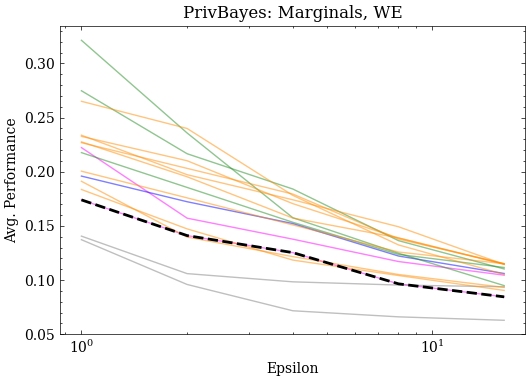


synthesizer: aim_jax
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,aim_jax
13,acs/gen-llama-MIX-UNIF,0.047246,0.021550,acs/national,aim_jax
14,acs/massachusetts_upsampled,0.043791,0.022333,acs/national,aim_jax
6,acs/gen-MIX-MAX,0.048967,0.023036,acs/national,aim_jax
0,acs/arbitrary,0.136584,0.061573,acs/national,aim_jax
7,acs/gen-MIX-UNIF,0.316296,0.141587,acs/national,aim_jax
8,acs/gen-claude-MIX-MAX,0.366615,0.164735,acs/national,aim_jax
11,acs/gen-gpt-MIX-UNIF,0.388758,0.173947,acs/national,aim_jax
10,acs/gen-gpt-MIX-MAX,0.395272,0.176871,acs/national,aim_jax
9,acs/gen-claude-MIX-UNIF,0.409340,0.183216,acs/national,aim_jax


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


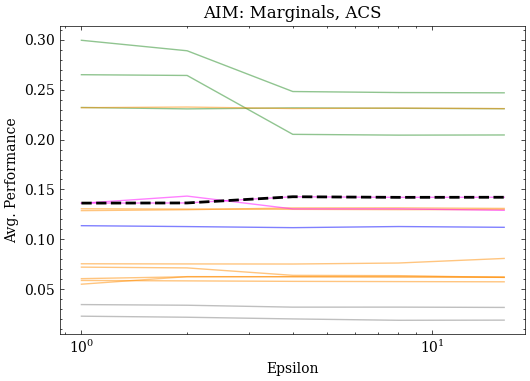

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,aim_jax
0,edad/2020,0.039546,0.020006,edad/2023,aim_jax
9,edad/gen-MIX-UNIF,0.171145,0.076658,edad/2023,aim_jax
10,edad/gen-claude-MIX-MAX,0.228834,0.102564,edad/2023,aim_jax
12,edad/gen-gpt-MIX-MAX,0.230526,0.103389,edad/2023,aim_jax
2,edad/arbitrary,0.255606,0.114764,edad/2023,aim_jax
11,edad/gen-claude-MIX-UNIF,0.276558,0.123997,edad/2023,aim_jax
13,edad/gen-gpt-MIX-UNIF,0.351285,0.157167,edad/2023,aim_jax
8,edad/gen-MIX-MAX,0.357656,0.160469,edad/2023,aim_jax
3,edad/baseline_domain,0.392764,0.175714,edad/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


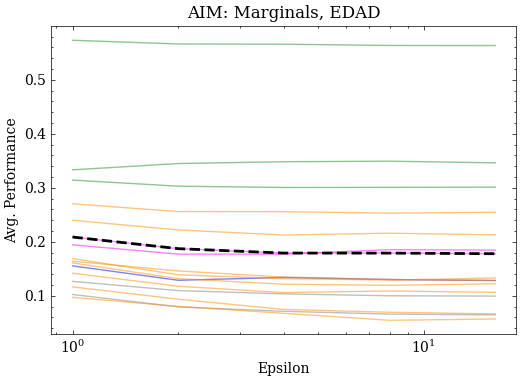

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,aim_jax
11,we/gen-claude-MIX-UNIF,0.041555,0.020013,we/2023,aim_jax
10,we/gen-claude-MIX-MAX,0.065739,0.029866,we/2023,aim_jax
0,we/2018,0.054815,0.032526,we/2023,aim_jax
3,we/baseline_domain,0.081488,0.037480,we/2023,aim_jax
15,we/gen-llama-MIX-UNIF,0.201428,0.090485,we/2023,aim_jax
4,we/baseline_univariate,0.223703,0.100207,we/2023,aim_jax
2,we/arbitrary,0.235875,0.107452,we/2023,aim_jax
7,we/csv-llama,0.316368,0.142391,we/2023,aim_jax
8,we/gen-MIX-MAX,0.352988,0.158008,we/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


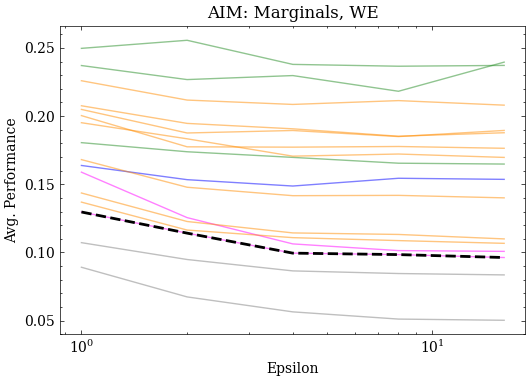


synthesizer: gem
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,gem
14,acs/massachusetts_upsampled,0.089393,0.040042,acs/national,gem
5,acs/csv-llama,0.100457,0.044950,acs/national,gem
0,acs/arbitrary,0.156472,0.070002,acs/national,gem
4,acs/csv-gpt,0.170099,0.076303,acs/national,gem
6,acs/gen-MIX-MAX,0.218920,0.097911,acs/national,gem
7,acs/gen-MIX-UNIF,0.234173,0.104741,acs/national,gem
11,acs/gen-gpt-MIX-UNIF,0.241978,0.108224,acs/national,gem
3,acs/csv-claude,0.246853,0.110444,acs/national,gem
13,acs/gen-llama-MIX-UNIF,0.259328,0.115987,acs/national,gem


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


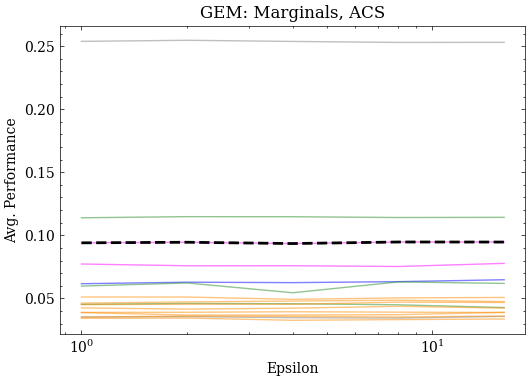

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,gem
4,edad/baseline_univariate,0.010625,0.005508,edad/2023,gem
0,edad/2020,0.064334,0.029379,edad/2023,gem
10,edad/gen-claude-MIX-MAX,0.115350,0.051856,edad/2023,gem
9,edad/gen-MIX-UNIF,0.116580,0.052213,edad/2023,gem
13,edad/gen-gpt-MIX-UNIF,0.120643,0.054226,edad/2023,gem
12,edad/gen-gpt-MIX-MAX,0.129964,0.058293,edad/2023,gem
3,edad/baseline_domain,0.139476,0.062520,edad/2023,gem
8,edad/gen-MIX-MAX,0.143586,0.064289,edad/2023,gem
11,edad/gen-claude-MIX-UNIF,0.144953,0.064965,edad/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)


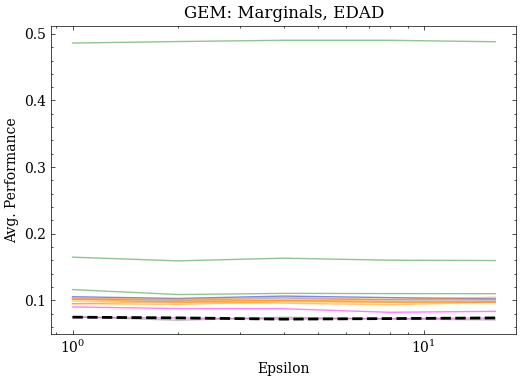

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,gem
8,we/gen-MIX-MAX,0.562616,0.251670,we/2023,gem
12,we/gen-gpt-MIX-MAX,0.587695,0.262970,we/2023,gem
9,we/gen-MIX-UNIF,0.612628,0.273986,we/2023,gem
4,we/baseline_univariate,0.621637,0.278079,we/2023,gem
6,we/csv-gpt,0.627038,0.280466,we/2023,gem
13,we/gen-gpt-MIX-UNIF,0.630935,0.282219,we/2023,gem
2,we/arbitrary,0.640508,0.286541,we/2023,gem
3,we/baseline_domain,0.640705,0.286569,we/2023,gem
11,we/gen-claude-MIX-UNIF,0.689167,0.308377,we/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


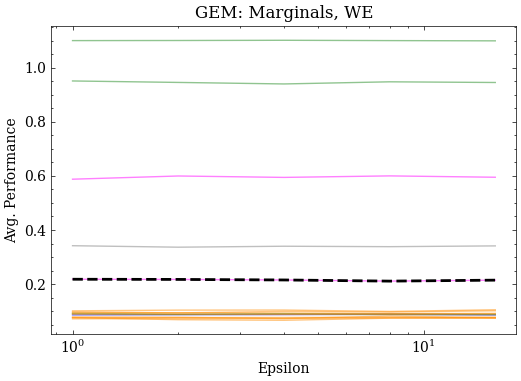

metric_group: classification_metrics

synthesizer: privbayes
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,privbayes
10,acs/gen-gpt-MIX-MAX,0.009368,0.005326,acs/national,privbayes
0,acs/arbitrary,0.010766,0.005772,acs/national,privbayes
14,acs/massachusetts_upsampled,0.013439,0.006643,acs/national,privbayes
11,acs/gen-gpt-MIX-UNIF,0.012488,0.007031,acs/national,privbayes
8,acs/gen-claude-MIX-MAX,0.017309,0.008906,acs/national,privbayes
4,acs/csv-gpt,0.019126,0.009414,acs/national,privbayes
12,acs/gen-llama-MIX-MAX,0.019549,0.010587,acs/national,privbayes
9,acs/gen-claude-MIX-UNIF,0.020943,0.010787,acs/national,privbayes
5,acs/csv-llama,0.024029,0.013049,acs/national,privbayes


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


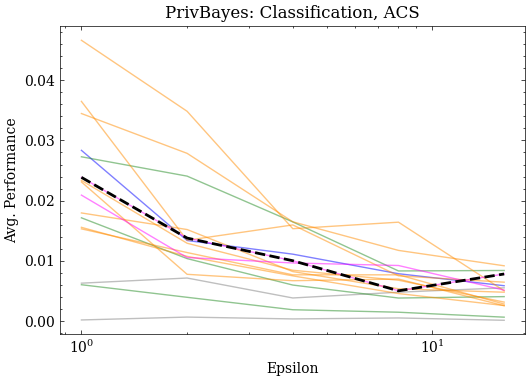

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,privbayes
0,edad/2020,0.038042,0.030371,edad/2023,privbayes
8,edad/gen-MIX-MAX,0.121971,0.063339,edad/2023,privbayes
6,edad/csv-gpt,0.135821,0.066058,edad/2023,privbayes
9,edad/gen-MIX-UNIF,0.091802,0.070297,edad/2023,privbayes
10,edad/gen-claude-MIX-MAX,0.181438,0.087008,edad/2023,privbayes
11,edad/gen-claude-MIX-UNIF,0.181738,0.089692,edad/2023,privbayes
12,edad/gen-gpt-MIX-MAX,0.143587,0.097175,edad/2023,privbayes
13,edad/gen-gpt-MIX-UNIF,0.177821,0.101332,edad/2023,privbayes
7,edad/csv-llama,0.151890,0.110481,edad/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)


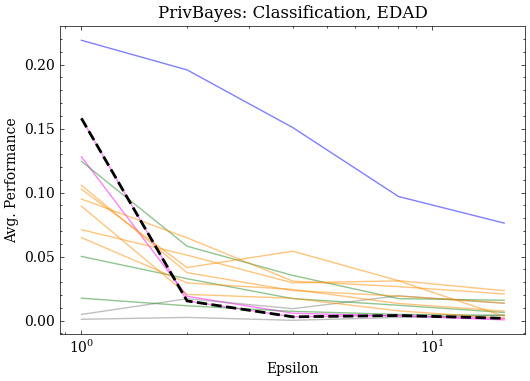

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,privbayes
14,we/gen-llama-MIX-MAX,0.061222,0.031256,we/2023,privbayes
12,we/gen-gpt-MIX-MAX,0.055592,0.035335,we/2023,privbayes
5,we/csv-claude,0.105207,0.050188,we/2023,privbayes
0,we/2018,0.101715,0.055020,we/2023,privbayes
9,we/gen-MIX-UNIF,0.112253,0.055788,we/2023,privbayes
13,we/gen-gpt-MIX-UNIF,0.141466,0.065423,we/2023,privbayes
11,we/gen-claude-MIX-UNIF,0.162937,0.085571,we/2023,privbayes
8,we/gen-MIX-MAX,0.226781,0.105160,we/2023,privbayes
10,we/gen-claude-MIX-MAX,0.164704,0.105446,we/2023,privbayes


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


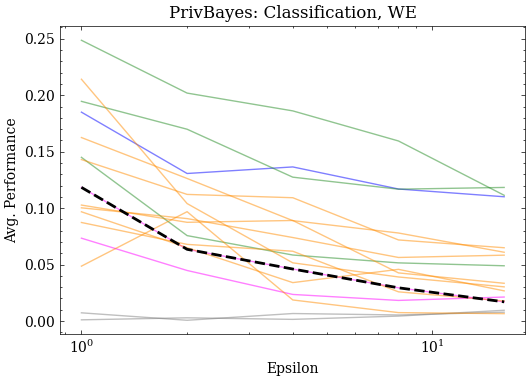


synthesizer: aim_jax
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,aim_jax
14,acs/massachusetts_upsampled,0.261541,0.131254,acs/national,aim_jax
8,acs/gen-claude-MIX-MAX,0.394245,0.235791,acs/national,aim_jax
5,acs/csv-llama,0.602217,0.269958,acs/national,aim_jax
4,acs/csv-gpt,0.672395,0.308385,acs/national,aim_jax
0,acs/arbitrary,0.529031,0.310430,acs/national,aim_jax
3,acs/csv-claude,0.661081,0.333201,acs/national,aim_jax
13,acs/gen-llama-MIX-UNIF,0.655811,0.338507,acs/national,aim_jax
7,acs/gen-MIX-UNIF,0.681153,0.359771,acs/national,aim_jax
6,acs/gen-MIX-MAX,0.687142,0.368831,acs/national,aim_jax


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


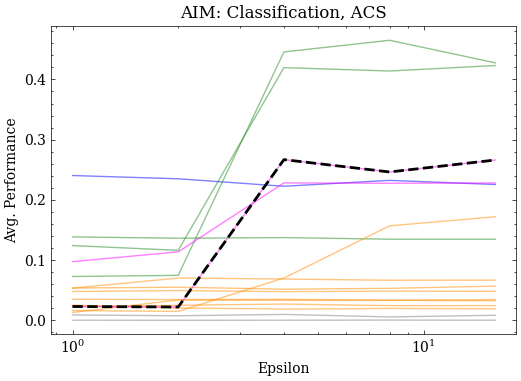

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,aim_jax
4,edad/baseline_univariate,0.012466,0.006881,edad/2023,aim_jax
7,edad/csv-llama,0.027311,0.013230,edad/2023,aim_jax
12,edad/gen-gpt-MIX-MAX,0.072674,0.033228,edad/2023,aim_jax
9,edad/gen-MIX-UNIF,0.094981,0.043019,edad/2023,aim_jax
11,edad/gen-claude-MIX-UNIF,0.120416,0.054447,edad/2023,aim_jax
3,edad/baseline_domain,0.116241,0.054653,edad/2023,aim_jax
13,edad/gen-gpt-MIX-UNIF,0.124825,0.057584,edad/2023,aim_jax
8,edad/gen-MIX-MAX,0.150959,0.067675,edad/2023,aim_jax
10,edad/gen-claude-MIX-MAX,0.245604,0.114065,edad/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)


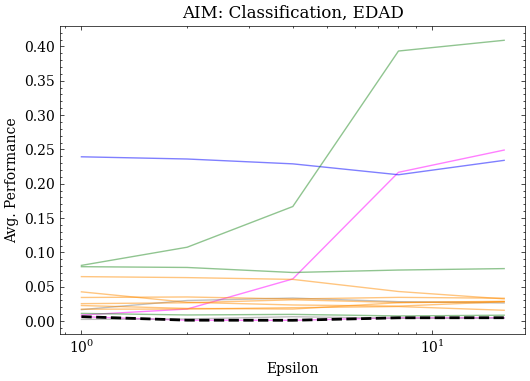

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,aim_jax
0,we/2018,0.085896,0.047011,we/2023,aim_jax
14,we/gen-llama-MIX-MAX,0.131202,0.066845,we/2023,aim_jax
13,we/gen-gpt-MIX-UNIF,0.160099,0.079726,we/2023,aim_jax
12,we/gen-gpt-MIX-MAX,0.296781,0.134317,we/2023,aim_jax
3,we/baseline_domain,0.317247,0.143921,we/2023,aim_jax
4,we/baseline_univariate,0.331387,0.149950,we/2023,aim_jax
8,we/gen-MIX-MAX,0.337558,0.152167,we/2023,aim_jax
9,we/gen-MIX-UNIF,0.334952,0.152280,we/2023,aim_jax
11,we/gen-claude-MIX-UNIF,0.480820,0.246189,we/2023,aim_jax


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


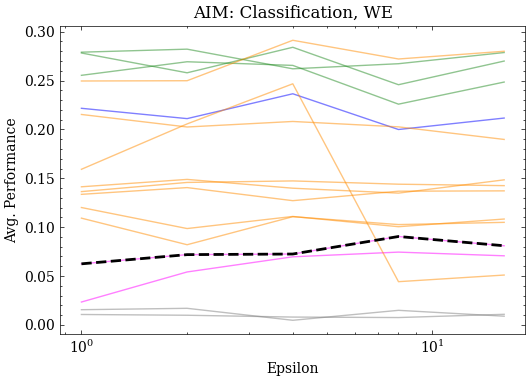


synthesizer: gem
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,gem
6,acs/gen-MIX-MAX,0.017408,0.009469,acs/national,gem
5,acs/csv-llama,0.020470,0.010262,acs/national,gem
7,acs/gen-MIX-UNIF,0.030834,0.015035,acs/national,gem
14,acs/massachusetts_upsampled,0.039289,0.018275,acs/national,gem
13,acs/gen-llama-MIX-UNIF,0.041033,0.019022,acs/national,gem
10,acs/gen-gpt-MIX-MAX,0.052451,0.024282,acs/national,gem
4,acs/csv-gpt,0.055728,0.025913,acs/national,gem
3,acs/csv-claude,0.064960,0.029830,acs/national,gem
12,acs/gen-llama-MIX-MAX,0.067593,0.030681,acs/national,gem


synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)
synth_method_name: Public
synth_method_name: Private


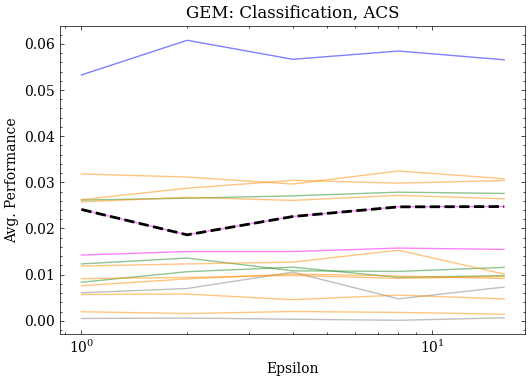

dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,gem
9,edad/gen-MIX-UNIF,0.002192,0.001460,edad/2023,gem
0,edad/2020,0.003099,0.001840,edad/2023,gem
12,edad/gen-gpt-MIX-MAX,0.005389,0.002652,edad/2023,gem
13,edad/gen-gpt-MIX-UNIF,0.007064,0.003545,edad/2023,gem
4,edad/baseline_univariate,0.008366,0.004462,edad/2023,gem
3,edad/baseline_domain,0.014700,0.006714,edad/2023,gem
5,edad/csv-claude,0.021162,0.009487,edad/2023,gem
7,edad/csv-llama,0.039733,0.018514,edad/2023,gem
6,edad/csv-gpt,0.043910,0.020422,edad/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)


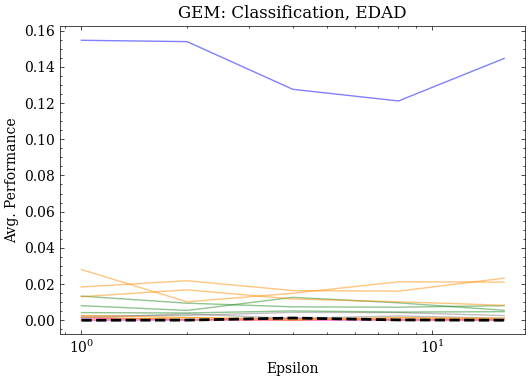

dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,gem
11,we/gen-claude-MIX-UNIF,0.007521,0.003731,we/2023,gem
3,we/baseline_domain,0.009652,0.004837,we/2023,gem
14,we/gen-llama-MIX-MAX,0.010615,0.005478,we/2023,gem
4,we/baseline_univariate,0.021099,0.014148,we/2023,gem
9,we/gen-MIX-UNIF,0.031025,0.015379,we/2023,gem
12,we/gen-gpt-MIX-MAX,0.046775,0.021657,we/2023,gem
10,we/gen-claude-MIX-MAX,0.069189,0.031487,we/2023,gem
0,we/2018,0.124597,0.064747,we/2023,gem
15,we/gen-llama-MIX-UNIF,0.157135,0.071199,we/2023,gem


synth_method_name: Public
synth_method_name: Private
synth_method_name: Arbitrary
synth_method_name: Domain (Baseline)
synth_method_name: Univariate (Baseline)
synth_method_name: CSV (Claude 3.5 Sonnet)
synth_method_name: CSV (GPT-4o)
synth_method_name: CSV (Llama 3.3 70B)
synth_method_name: Agent (All, Max Cov.)
synth_method_name: Agent (All, Unif.)
synth_method_name: Agent (Claude 3.5 Sonnet, Max Cov.)
synth_method_name: Agent (Claude 3.5 Sonnet, Unif.)
synth_method_name: Agent (GPT-4o, Max Cov.)
synth_method_name: Agent (GPT-4o, Unif.)
synth_method_name: Agent (Llama 3.3 70B, Max Cov.)
synth_method_name: Agent (Llama 3.3 70B, Unif.)


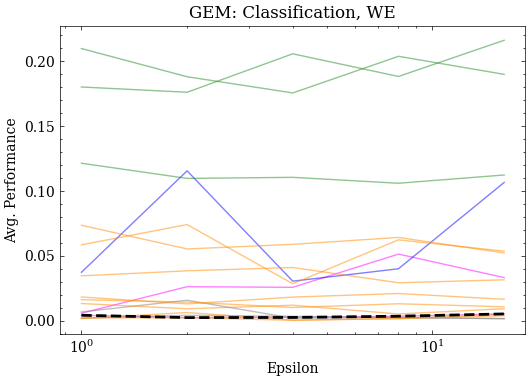

In [ ]:
import pandas as pd
import numpy as np

epsilons = [1, 2, 4, 8, 16]

all_distance_dfs = []
normalized_comparison = False
for key in METRIC_GROUPS.keys():

    print(f"metric_group: {key}")
    metrics_for_key = METRIC_GROUPS[key]
    for synth_method in ['privbayes', 'aim_jax', 'gem']: # ['privbayes', 'aim_jax', 'gem']:
        print()
        print(f"synthesizer: {synth_method}")

        filtered_df = report_df[
            (report_df['synth_name'] == synth_method) &
            (report_df['epsilon'].isin(epsilons))
        ]

        # first, aggregate the chosen_val_on_dataset across metrics_for_key
        filtered_df_for_metrics = filtered_df[filtered_df['metric'].isin(metrics_for_key)]
        aggregated_df = filtered_df_for_metrics.groupby(['dataset_name', 'epsilon', 'reference_dataset_name'])['chosen_val_on_dataset'].mean().reset_index()
        for ref_ds_name in reference_data_mapping.values():
            print(f'dataset_name: {ref_ds_name}')
            # agg chosen_val_on_dataset to take the mean across all metrics for each dataset_name, epsilon
            ref_agged_df = aggregated_df[aggregated_df['reference_dataset_name'] == ref_ds_name]
            
            # take epsilons as columns and dataset_names as rows
            pivot_df = ref_agged_df.pivot(index='dataset_name', columns='epsilon', values='chosen_val_on_dataset')

            # drop datasets that do not have all epsilon values (if any), not fair comparison
            pivot_df = pivot_df.dropna()

            # optionally normalize the values so that they're all in the range [0, 1]
            # NOTE: this way, its a relative comparison, so choose the epsilon value
            # based on a leveling out in performance

            if normalized_comparison:
                normalized_df = pivot_df.copy()
                for dataset in normalized_df.index:
                    row = normalized_df.loc[dataset]
                    min_val = row.min()
                    max_val = row.max()
                    if max_val - min_val != 0:
                        normalized_df.loc[dataset] = (row - min_val) / (max_val - min_val)
                    else:
                        normalized_df.loc[dataset] = 0
            else:
                normalized_df = pivot_df

            if ref_ds_name not in normalized_df.index:
                raise ValueError(f"ref dataset {ref_ds_name} not present in the data")

            reference_vector = normalized_df.loc[ref_ds_name].values

            # we'll do both L1 and L2 distance between the vectors 
            def compute_distances(row, ref_vector):
                l1 = np.sum(np.abs(row - ref_vector))
                l2 = np.sqrt(np.sum((row - ref_vector) ** 2))
                return pd.Series({'L1_distance': l1, 'L2_distance': l2})

            distance_df = normalized_df.apply(lambda row: compute_distances(row.values, reference_vector), axis=1)

            distance_df = distance_df.reset_index()

            distance_df_sorted = distance_df.sort_values(['L2_distance'])

            # add columns for the reference dataset and synth
            distance_df_sorted['reference_dataset_name'] = ref_ds_name
            distance_df_sorted['synth_name'] = synth_method

            print("method by method performance compared to reference dataset")
            display(distance_df_sorted)

            all_distance_dfs.append(distance_df_sorted)
            with plt.style.context(['science']):
                plt.rc('text', usetex=False)

                # plot lineplots, comparing reference vector to each row vector
                fig, ax = plt.subplots()
                # fig size
                fig.set_size_inches(6, 4)

                for i, row in normalized_df.iterrows():
                    # name of row
                    if i.split('/')[0] == 'we':
                        synth_method_name = we_method_name_map.get(i, i)
                    elif i.split('/')[0] == 'acs':
                        synth_method_name = acs_method_name_map.get(i, i)
                    elif i.split('/')[0] == 'edad':
                        synth_method_name = edad_method_name_map.get(i, i)
                    
                    print(f"synth_method_name: {synth_method_name}")
                    # grouping
                    method_group = method_grouping.get(synth_method_name, "Other")
                    ax.plot(row.index, row.values, label=i, alpha=0.5, color=grouping_colors.get(method_group, "magenta"))

                ax.plot(normalized_df.columns, reference_vector, label=ref_ds_name, linestyle='--', color='black', linewidth=2)
                ax.set_xlabel('Epsilon')
                ax.set_ylabel('Avg. Performance')
                ax.set_xscale('log')

                # make title human readable
                ax.set_title(f"{synth_method_name_map[synth_method]}: {metric_group_map[key]}, {reference_dataset_name_map[ref_ds_name]}")
                # ax.legend()

                # save plot as pdf
                plt.savefig(f"./plots/line_plots/{synth_method_name_map[synth_method]}_{metric_group_map[key]}_{reference_dataset_name_map[ref_ds_name]}.pdf", bbox_inches='tight')

                plt.show()


all_distance_df = pd.concat(all_distance_dfs)

## Adding plotting for these results

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


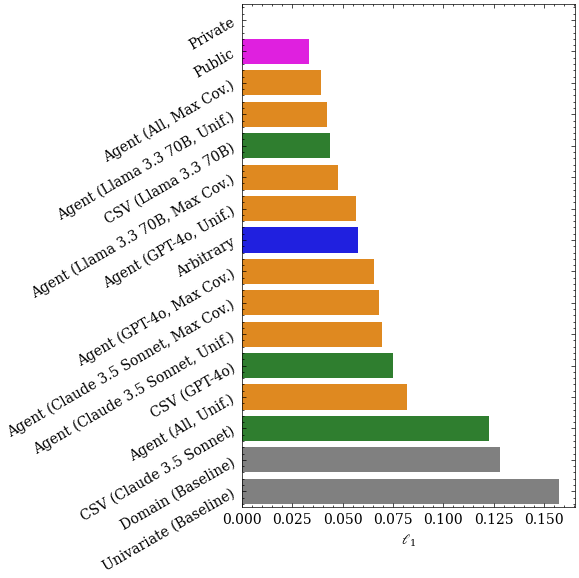

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


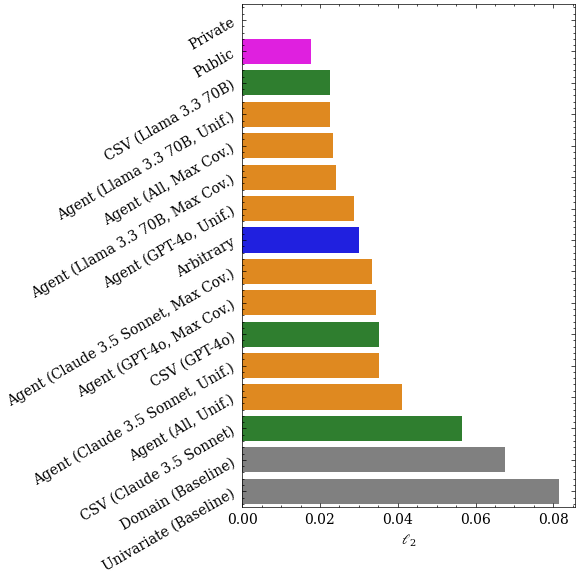

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


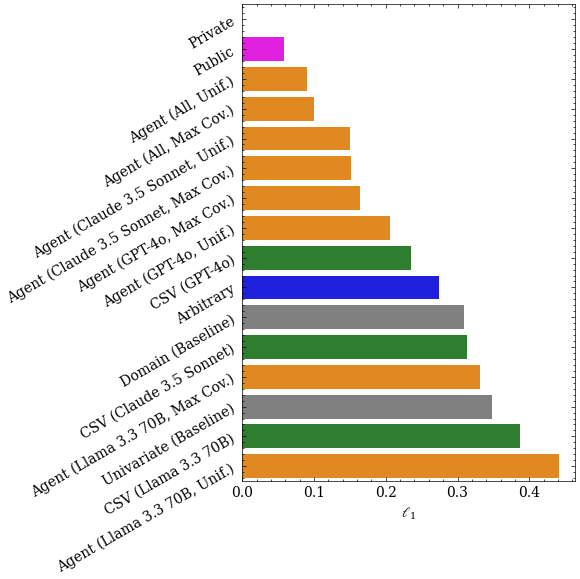

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


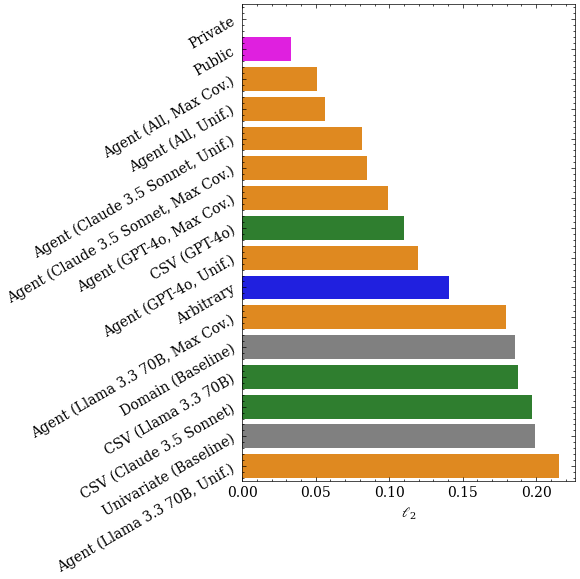

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


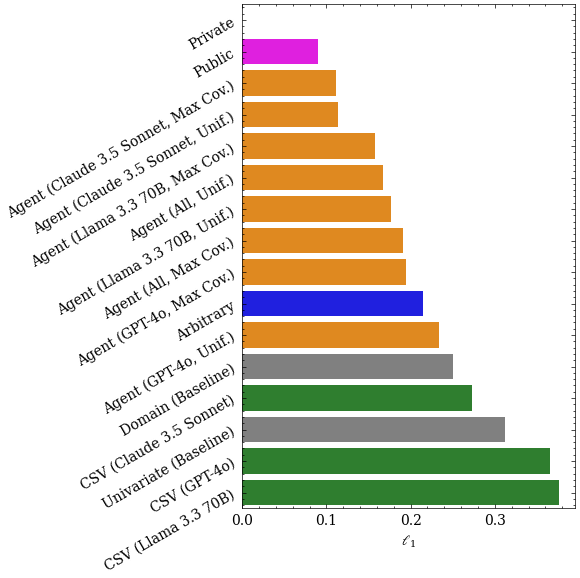

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


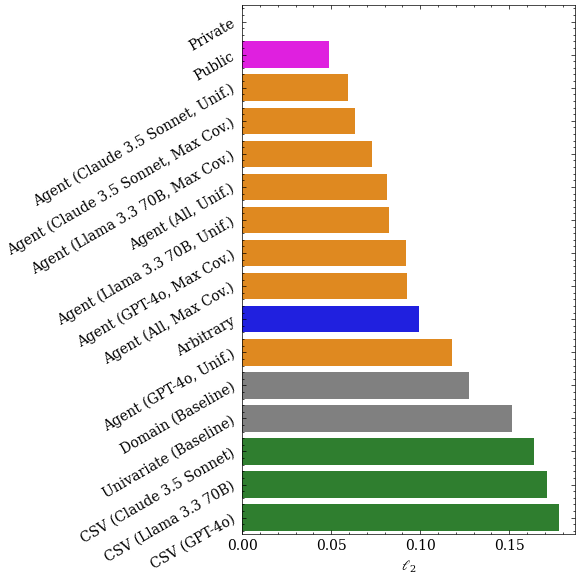

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


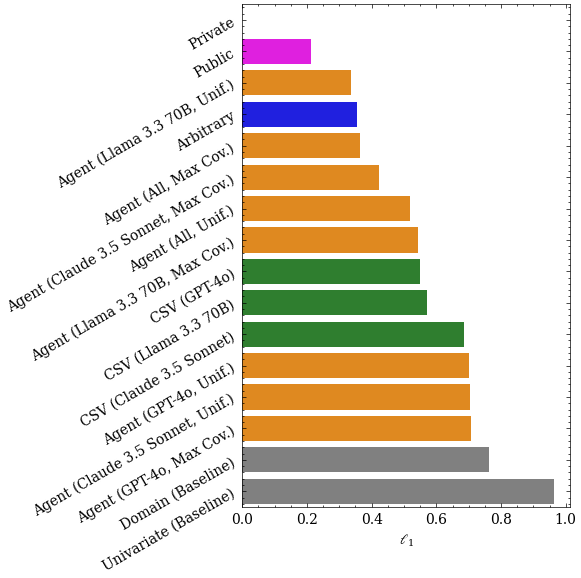

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


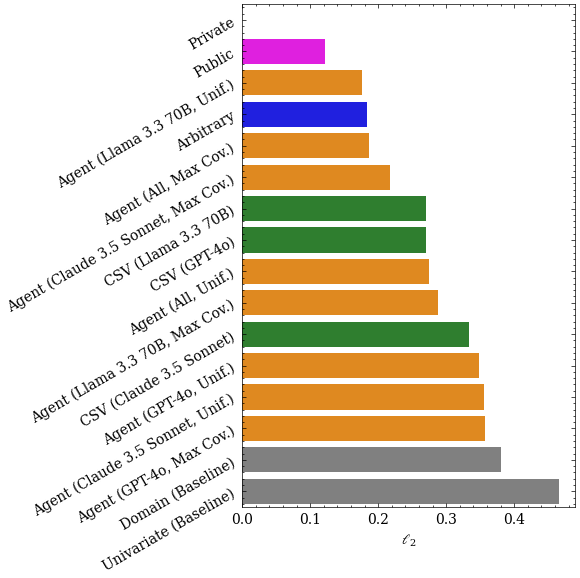

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


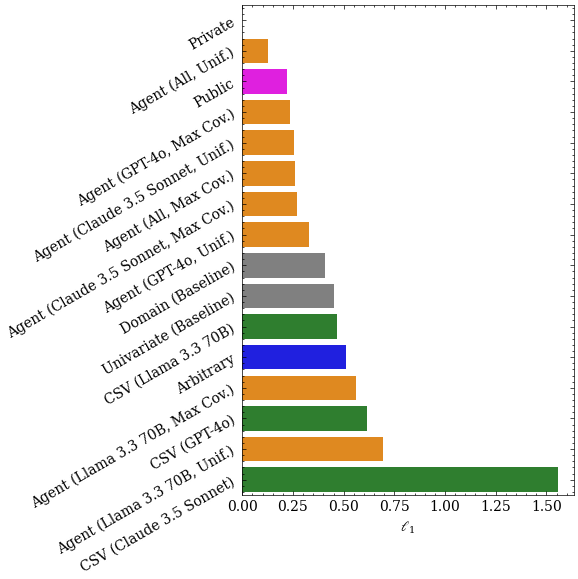

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


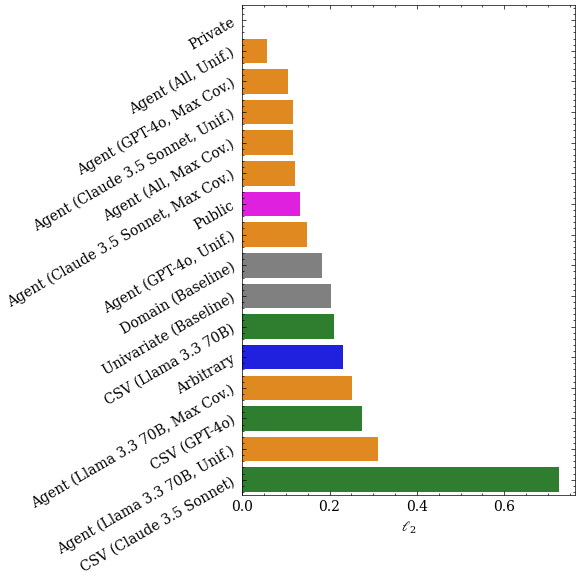

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


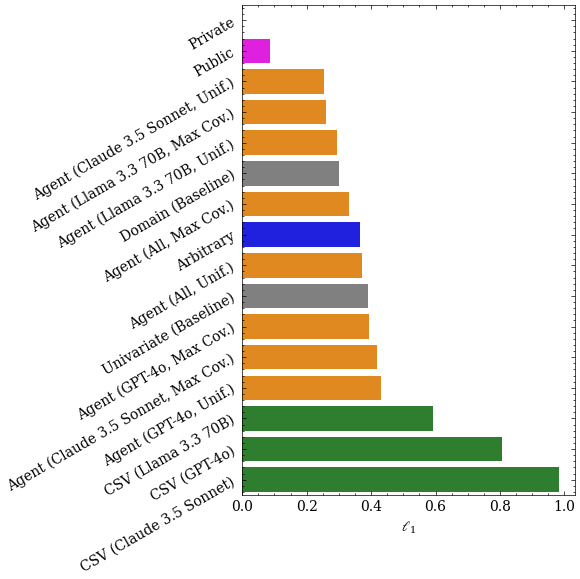

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


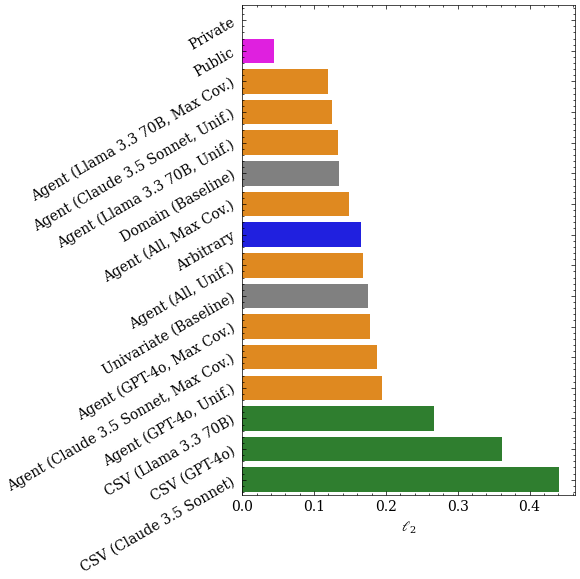

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


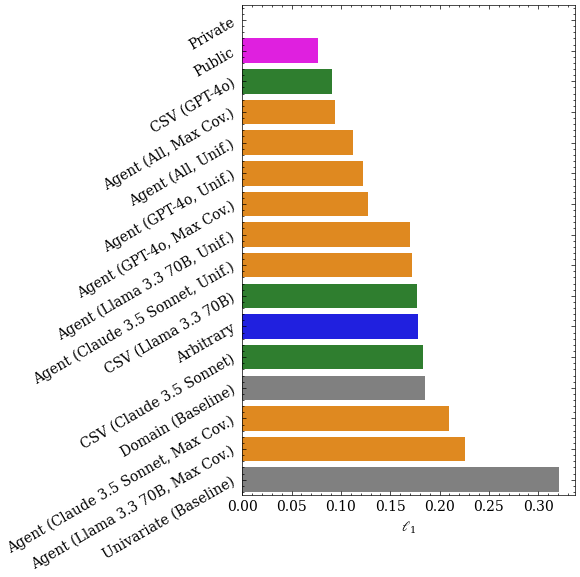

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


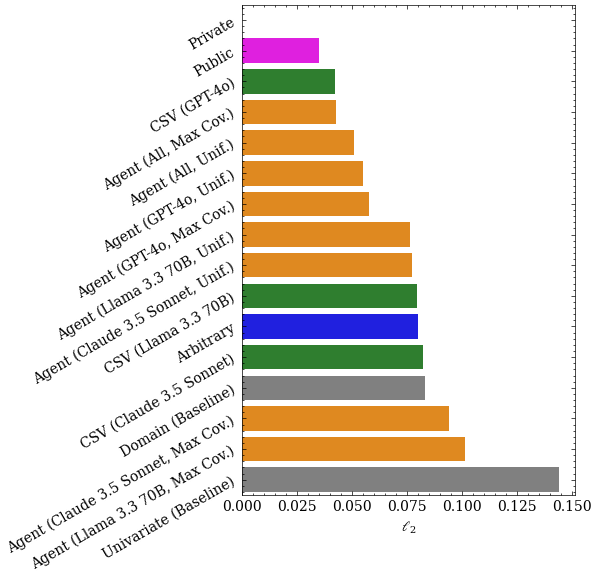

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


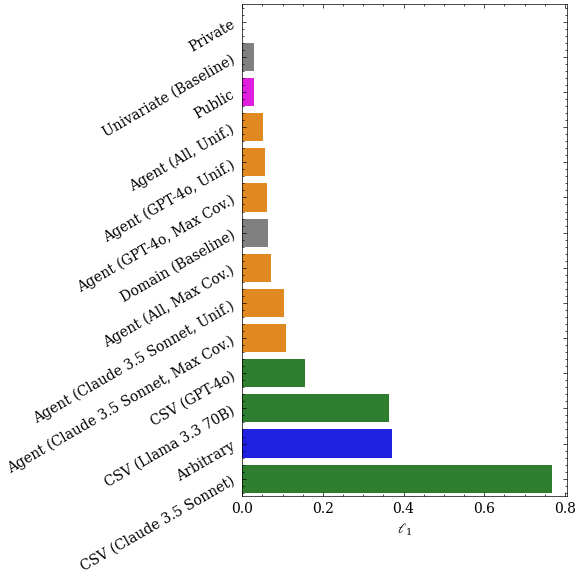

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


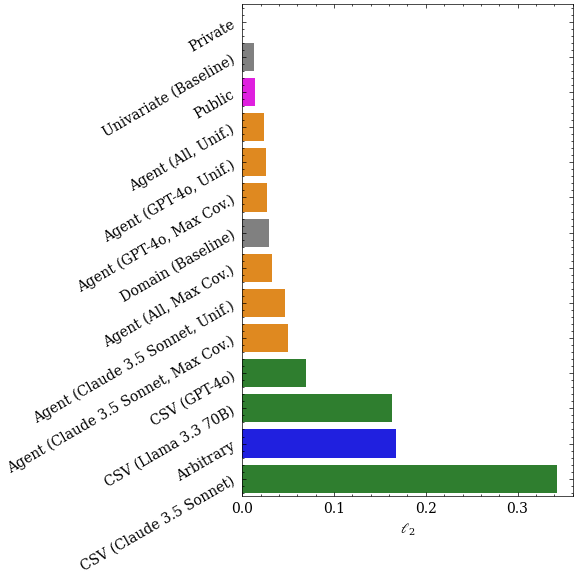

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


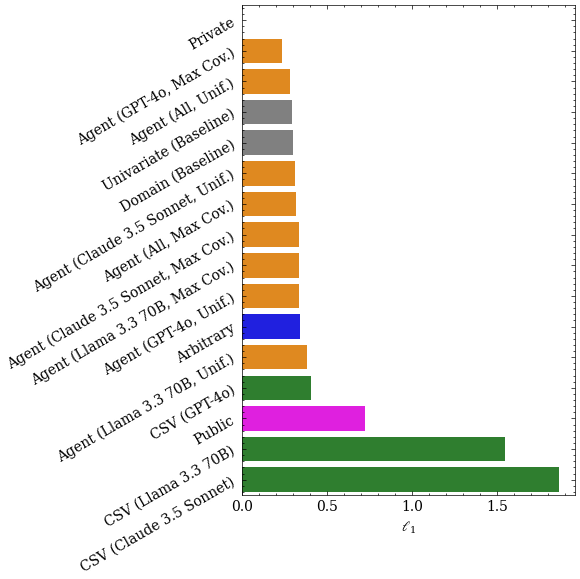

/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2423600/3438426192.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


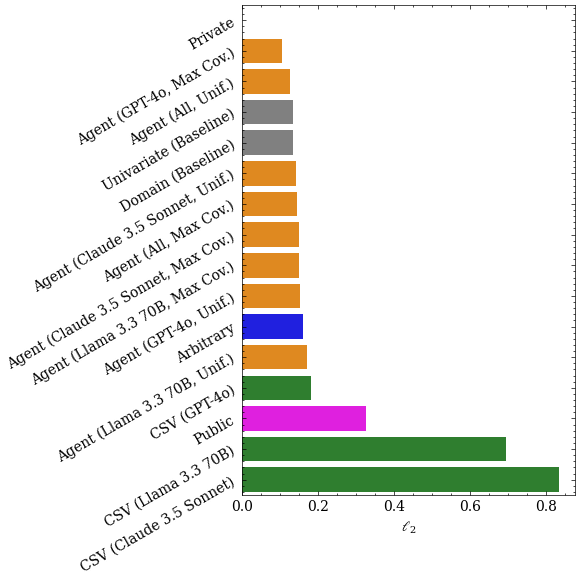

In [6]:
all_name_map = {}
all_name_map.update(we_method_name_map)
all_name_map.update(acs_method_name_map)
all_name_map.update(edad_method_name_map)

unique_combos = all_distance_df[['reference_dataset_name', 'synth_name']].drop_duplicates()

with plt.style.context(['science']):
    plt.rc('text', usetex=False)
    for _, combo in unique_combos.iterrows():
        ref = combo['reference_dataset_name']
        synth = combo['synth_name']
        
        subset_df = all_distance_df[
            (all_distance_df['reference_dataset_name'] == ref) &
            (all_distance_df['synth_name'] == synth)
        ]
        
        for dist_measure in ['L1_distance', 'L2_distance']:
            sorted_df = subset_df.sort_values(by=dist_measure).copy()
            
            sorted_df['method_label'] = sorted_df['dataset_name'].map(all_name_map).fillna(sorted_df['dataset_name'])

            sorted_order = sorted_df.groupby('method_label')[dist_measure].mean().sort_values().index
            
            plt.figure(figsize=(6, 6))
            ax = sns.barplot(
                data=sorted_df,
                x=dist_measure,
                y='method_label',
                orient='h',
                order=sorted_order,
                palette=[grouping_colors.get(method_grouping.get(x, "Other"), "magenta") for x in sorted_order],
                ci=None
            )
            
            for label in ax.get_yticklabels():
                label.set_rotation(30)

            # dist_measure mapping:
            # use latex \ell_1 and \ell_2
            if dist_measure == 'L1_distance':
                dist_measure = r"$\ell_1$"
                dist_measure_for_file = 'L1_distance'
            elif dist_measure == 'L2_distance':
                dist_measure = r"$\ell_2$"
                dist_measure_for_file = 'L2_distance'
            
            # plt.title(f"{reference_dataset_name_map[ref]} - {synth_method_name_map[synth]}")
            plt.xlabel(f"{dist_measure}")
            plt.ylabel("")
            plt.tight_layout()
            plt.savefig(f"plots/{dist_measure_for_file}_{reference_dataset_name_map[ref]}_{synth_method_name_map[synth]}.pdf", bbox_inches="tight")
            plt.show()


### TODO: pareto frontier of these results

In [ ]:
# acs/national_L1 & edad/2023_L1 & we/2023_L1 & acs/national_L2 & edad/2023_L2 & we/2023_L2
# name mapping for these to human readable
all_name_map = {
    'Method': 'Method',
    'acs/national_L1': 'ACS L1',
    'edad/2023_L1': 'EDAD L1',
    'we/2023_L1': 'WE L1',
    'acs/national_L2': 'ACS L2',
    'edad/2023_L2': 'EDAD L2',
    'we/2023_L2': 'WE L2',
}

def df_to_latex_medals_priv_util(
    df,
    caption="default caption",
    label="tab:default",
    float_format=".3f",
    largest_is_better=False,
    index_name="Method",
    columns_to_exclude=[]
) -> str:
    import pandas as pd
    import numpy as np

    def get_friendly_name(method):
        if method is None:
            return "Unknown"
        method_str = str(method)
        if "we/" + method_str in we_method_name_map.keys():
            return we_method_name_map["we/" + method_str]
        elif "acs/" + method_str in acs_method_name_map.keys():
            return acs_method_name_map["acs/" + method_str]
        elif "edad/" + method_str in edad_method_name_map.keys():
            return edad_method_name_map["edad/" + method_str]
        else:
            return method_str

    if "dataset_name" in df.columns:
        df = df.set_index("dataset_name")
        df.index = df.index.map(get_friendly_name)

    df = df.drop(columns=columns_to_exclude, errors='ignore', axis=1)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    ranks = pd.DataFrame(index=df.index)
    for col in numeric_cols:
        ranks[col] = df[col].rank(method='dense', ascending=not largest_is_better)

    lines = []
    lines.append(r"\begin{tabular}{l" + "c" * len(df.columns) + "}")
    lines.append(r"\toprule")
    header_cols = [index_name] + [str(col) for col in df.columns]
    header_cols = [all_name_map[col] for col in header_cols]
    lines.append(" & ".join(header_cols) + r" \\")
    lines.append(r"\midrule")

    for i, (idx, row) in enumerate(df.iterrows()):
        row_vals = [str(idx)]
        for col in df.columns:
            val = row[col]
            if col in numeric_cols and pd.notnull(val):
                val_str = f"{val:{float_format}}"
                rank_val = ranks.iloc[i][col]
                if rank_val == 1:
                    val_str = r"\cellcolor{gold!30}" + val_str
                elif rank_val == 2:
                    val_str = r"\cellcolor{silver!30}" + val_str
                elif rank_val == 3:
                    val_str = r"\cellcolor{bronze!30}" + val_str
                row_vals.append(val_str)
            else:
                row_vals.append(str(val))
        lines.append(" & ".join(row_vals) + r" \\")
    
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")

    latex_str = "\n".join(lines)
    return latex_str


In [ ]:
import numpy as np
import pandas as pd

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

public_data_mapping = {
    "acs": "acs/massachusetts_upsampled",
    "edad": "edad/2020",
    "we": "we/2018",
}

all_distance_df = all_distance_df[~all_distance_df['dataset_name'].isin(reference_data_mapping.values())]
all_distance_df = all_distance_df[~all_distance_df['dataset_name'].isin(public_data_mapping.values())]

def is_pareto_efficient(costs):
    # find the Pareto-efficient points for array n_points, n_costs
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # any point that is dominated by point i is not efficient
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True 
    return is_efficient

# pivot for L1 and L2 for each reference dataset
pivot_l1 = all_distance_df.pivot_table(
    index=['synth_name', 'dataset_name'],
    columns='reference_dataset_name',
    values='L1_distance'
).reset_index()

pivot_l2 = all_distance_df.pivot_table(
    index=['synth_name', 'dataset_name'],
    columns='reference_dataset_name',
    values='L2_distance'
).reset_index()

# for each pivot, for each dataset_name, remove text before "/". this will lead to duplicate dataset names.
pivot_l1['dataset_name'] = pivot_l1['dataset_name'].apply(lambda x: x.split("/")[1])
pivot_l2['dataset_name'] = pivot_l2['dataset_name'].apply(lambda x: x.split("/")[1])

# now, for each row, there will be 1 column with a value, and the rest will be NaN
# collapse so that each dataset name is only 1 row, with no NaNs
pivot_l1 = pivot_l1.groupby(['dataset_name','synth_name']).first().reset_index()
pivot_l2 = pivot_l2.groupby(['dataset_name','synth_name']).first().reset_index()

# rename columns of each so that end with _L1 and _L2
pivot_l1.columns = ['dataset_name', 'synth_name'] + [f"{ref}_L1" for ref in pivot_l1.columns if ref not in ['synth_name', 'dataset_name']]
pivot_l2.columns = ['dataset_name', 'synth_name'] + [f"{ref}_L2" for ref in pivot_l2.columns if ref not in ['synth_name', 'dataset_name']]

merged_pivot = pd.merge(pivot_l1, pivot_l2, on=['synth_name', 'dataset_name'])

In [ ]:
synthesizers = merged_pivot['synth_name'].unique()

for synth in synthesizers:
    synth_df = merged_pivot[merged_pivot['synth_name'] == synth]
    print()
    print(f"pareto frontier for {synth}")
    
    distance_cols = [col for col in merged_pivot.columns if col.endswith('_L1') or col.endswith('_L2')]
    cost_matrix = synth_df[distance_cols].values
    
    pareto_mask = is_pareto_efficient(cost_matrix)
    pareto_front = synth_df[pareto_mask]
    
    display(pareto_front[['dataset_name'] + distance_cols])
    columns_to_exclude = 'synth_name'
    print(df_to_latex_medals_priv_util(pareto_front, columns_to_exclude=columns_to_exclude))
    # save pareto_front in a tex file
    with open(f"priv_util_pareto_front_{synth}.tex", "w") as f:
        f.write(df_to_latex_medals_priv_util(pareto_front, columns_to_exclude=columns_to_exclude))

        

    # also compute pareto frontier for average of L1 and average L2
    synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
    synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)
    avg_cost_matrix = synth_df[['avg_L1', 'avg_L2']].values

    avg_pareto_mask = is_pareto_efficient(avg_cost_matrix)
    avg_pareto_front = synth_df[avg_pareto_mask]

    display(avg_pareto_front[['dataset_name', 'avg_L1', 'avg_L2']])



pareto frontier for aim_jax


,dataset_name,acs/national_L1,edad/2023_L1,we/2023_L1,acs/national_L2,edad/2023_L2,we/2023_L2
0,arbitrary,0.353433,0.509856,0.366714,0.183570,0.231427,0.165898
18,gen-MIX-MAX,0.363607,0.257795,0.330009,0.186094,0.115650,0.148153
21,gen-MIX-UNIF,0.518845,0.125569,0.373195,0.274416,0.056633,0.167878
27,gen-claude-MIX-UNIF,0.704922,0.257068,0.253533,0.355250,0.115349,0.124281
36,gen-llama-MIX-MAX,0.543478,0.559123,0.259841,0.288408,0.251167,0.119252
39,gen-llama-MIX-UNIF,0.337303,0.695832,0.295460,0.176123,0.311731,0.133190


\begin{tabular}{lcccccc}
\toprule
Method & ACS L1 & EDAD L1 & WE L1 & ACS L2 & EDAD L2 & WE L2 \\
\midrule
Arbitrary (Baseline) & \cellcolor{silver!30}0.353 & 0.510 & 0.367 & \cellcolor{silver!30}0.184 & 0.231 & 0.166 \\
Agent (All, Max Cov.) & \cellcolor{bronze!30}0.364 & \cellcolor{bronze!30}0.258 & 0.330 & \cellcolor{bronze!30}0.186 & \cellcolor{bronze!30}0.116 & 0.148 \\
Agent (All, Unif.) & 0.519 & \cellcolor{gold!30}0.126 & 0.373 & 0.274 & \cellcolor{gold!30}0.057 & 0.168 \\
Agent (Claude, Unif.) & 0.705 & \cellcolor{silver!30}0.257 & \cellcolor{gold!30}0.254 & 0.355 & \cellcolor{silver!30}0.115 & \cellcolor{silver!30}0.124 \\
Agent (LLaMA, Max Cov.) & 0.543 & 0.559 & \cellcolor{silver!30}0.260 & 0.288 & 0.251 & \cellcolor{gold!30}0.119 \\
Agent (LLaMA, Unif.) & \cellcolor{gold!30}0.337 & 0.696 & \cellcolor{bronze!30}0.295 & \cellcolor{gold!30}0.176 & 0.312 & \cellcolor{bronze!30}0.133 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_2157471/3721214336.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
/tmp/ipykernel_2157471/3721214336.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)


,dataset_name,avg_L1,avg_L2
18,gen-MIX-MAX,0.317137,0.149966



pareto frontier for gem


,dataset_name,acs/national_L1,edad/2023_L1,we/2023_L1,acs/national_L2,edad/2023_L2,we/2023_L2
7,baseline_univariate,0.321135,0.028138,0.293839,0.144047,0.013285,0.133110
13,csv-gpt,0.091157,0.154525,0.401955,0.042001,0.069616,0.180222
19,gen-MIX-MAX,0.093821,0.071057,0.318074,0.042796,0.032523,0.144049
22,gen-MIX-UNIF,0.111763,0.050847,0.279748,0.050587,0.023642,0.125846
31,gen-gpt-MIX-MAX,0.127446,0.060503,0.232143,0.057571,0.027342,0.104934


\begin{tabular}{lcccccc}
\toprule
Method & ACS L1 & EDAD L1 & WE L1 & ACS L2 & EDAD L2 & WE L2 \\
\midrule
Univariate (Baseline) & 0.321 & \cellcolor{gold!30}0.028 & \cellcolor{bronze!30}0.294 & 0.144 & \cellcolor{gold!30}0.013 & \cellcolor{bronze!30}0.133 \\
CSV (GPT) & \cellcolor{gold!30}0.091 & 0.155 & 0.402 & \cellcolor{gold!30}0.042 & 0.070 & 0.180 \\
Agent (All, Max Cov.) & \cellcolor{silver!30}0.094 & 0.071 & 0.318 & \cellcolor{silver!30}0.043 & 0.033 & 0.144 \\
Agent (All, Unif.) & \cellcolor{bronze!30}0.112 & \cellcolor{silver!30}0.051 & \cellcolor{silver!30}0.280 & \cellcolor{bronze!30}0.051 & \cellcolor{silver!30}0.024 & \cellcolor{silver!30}0.126 \\
Agent (GPT, Max Cov.) & 0.127 & \cellcolor{bronze!30}0.061 & \cellcolor{gold!30}0.232 & 0.058 & \cellcolor{bronze!30}0.027 & \cellcolor{gold!30}0.105 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_2157471/3721214336.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
/tmp/ipykernel_2157471/3721214336.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)


,dataset_name,avg_L1,avg_L2
31,gen-gpt-MIX-MAX,0.140031,0.063282



pareto frontier for privbayes


,dataset_name,acs/national_L1,edad/2023_L1,we/2023_L1,acs/national_L2,edad/2023_L2,we/2023_L2
17,csv-llama,0.043685,0.386518,0.376376,0.022597,0.187676,0.170926
20,gen-MIX-MAX,0.039187,0.099860,0.190706,0.023254,0.050757,0.092323
23,gen-MIX-UNIF,0.081992,0.090500,0.167211,0.040963,0.056159,0.081310
26,gen-claude-MIX-MAX,0.067865,0.152199,0.111433,0.033456,0.085158,0.063177
29,gen-claude-MIX-UNIF,0.069515,0.150642,0.114301,0.035250,0.081769,0.059356
32,gen-gpt-MIX-MAX,0.065297,0.164181,0.194252,0.034376,0.098903,0.092267
38,gen-llama-MIX-MAX,0.047812,0.331648,0.157849,0.024075,0.179731,0.073070
41,gen-llama-MIX-UNIF,0.042295,0.441657,0.176987,0.022638,0.215631,0.082175


\begin{tabular}{lcccccc}
\toprule
Method & ACS L1 & EDAD L1 & WE L1 & ACS L2 & EDAD L2 & WE L2 \\
\midrule
CSV (LLaMA) & \cellcolor{bronze!30}0.044 & 0.387 & 0.376 & \cellcolor{gold!30}0.023 & 0.188 & 0.171 \\
Agent (All, Max Cov.) & \cellcolor{gold!30}0.039 & \cellcolor{silver!30}0.100 & 0.191 & \cellcolor{bronze!30}0.023 & \cellcolor{gold!30}0.051 & 0.092 \\
Agent (All, Unif.) & 0.082 & \cellcolor{gold!30}0.091 & 0.167 & 0.041 & \cellcolor{silver!30}0.056 & 0.081 \\
Agent (Claude, Max Cov.) & 0.068 & 0.152 & \cellcolor{gold!30}0.111 & 0.033 & 0.085 & \cellcolor{silver!30}0.063 \\
Agent (Claude, Unif.) & 0.070 & \cellcolor{bronze!30}0.151 & \cellcolor{silver!30}0.114 & 0.035 & \cellcolor{bronze!30}0.082 & \cellcolor{gold!30}0.059 \\
Agent (GPT, Max Cov.) & 0.065 & 0.164 & 0.194 & 0.034 & 0.099 & 0.092 \\
Agent (LLaMA, Max Cov.) & 0.048 & 0.332 & \cellcolor{bronze!30}0.158 & 0.024 & 0.180 & \cellcolor{bronze!30}0.073 \\
Agent (LLaMA, Unif.) & \cellcolor{silver!30}0.042 & 0.442 & 0.177 

/tmp/ipykernel_2157471/3721214336.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
/tmp/ipykernel_2157471/3721214336.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)


,dataset_name,avg_L1,avg_L2
20,gen-MIX-MAX,0.109918,0.055445


In [61]:
columns_to_exclude = 'synth_name'
print(df_to_latex_medals_priv_util(pareto_front, columns_to_exclude=columns_to_exclude))

\begin{tabular}{lcccccc}
\toprule
Method & ACS L1 & EDAD L1 & WE L1 & ACS L2 & EDAD L2 & WE L2 \\
\midrule
CSV (LLaMA) & \cellcolor{bronze!30}0.044 & 0.387 & 0.376 & \cellcolor{gold!30}0.023 & 0.188 & 0.171 \\
Agent (All, Max Cov.) & \cellcolor{gold!30}0.039 & \cellcolor{silver!30}0.100 & 0.191 & \cellcolor{bronze!30}0.023 & \cellcolor{gold!30}0.051 & 0.092 \\
Agent (All, Unif.) & 0.082 & \cellcolor{gold!30}0.091 & 0.167 & 0.041 & \cellcolor{silver!30}0.056 & 0.081 \\
Agent (Claude, Max Cov.) & 0.068 & 0.152 & \cellcolor{gold!30}0.111 & 0.033 & 0.085 & \cellcolor{silver!30}0.063 \\
Agent (Claude, Unif.) & 0.070 & \cellcolor{bronze!30}0.151 & \cellcolor{silver!30}0.114 & 0.035 & \cellcolor{bronze!30}0.082 & \cellcolor{gold!30}0.059 \\
Agent (GPT, Max Cov.) & 0.065 & 0.164 & 0.194 & 0.034 & 0.099 & 0.092 \\
Agent (LLaMA, Max Cov.) & 0.048 & 0.332 & \cellcolor{bronze!30}0.158 & 0.024 & 0.180 & \cellcolor{bronze!30}0.073 \\
Agent (LLaMA, Unif.) & \cellcolor{silver!30}0.042 & 0.442 & 0.177 